In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Preparation

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import listdir
import glob

In [3]:
base_dir = '../input/breast-histopathology-images/*/'
file=os.listdir('../input/breast-histopathology-images')
print(len(file))

280


In [4]:
file[:5]

['10295', '10304', '12868', '10274', '12818']

In [5]:
patient_list = list(glob.glob(base_dir))
print('Number of the patient :'+' '+str(len(patient_list)))

Number of the patient : 280


In [6]:
test=[glob.glob(patient_list[i]+'/*/*') for i in range(0,len(patient_list))]

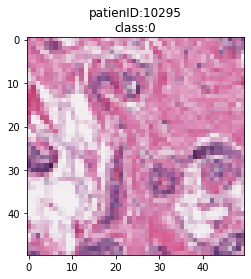

In [7]:
from skimage import io
img_sample = io.imread(test[0][0])
plt.title('patienID:'
          +str(test[0][0].split('/')[3])+'\n'
         'class:'+str(test[0][0].split('/')[4]))
plt.imshow(img_sample)

# Creating DataFrame

In [8]:
patient_ID = [test[i][x].split('/')[3]for i in range(0,len(test))for x in range(0,len(test[i]))]
class_test = [test[i][x].split('/')[4]for i in range(0,len(test))for x in range(0 ,len(test[i]))]
patient_pathes = [test[i][x]for i in range(0,len(test))for x in range(0,len(test[i]))]

In [9]:
d = {'patient_ID':patient_ID,'pathes':patient_pathes,'diagnosis':class_test}

import dask.dataframe as dd
df = pd.DataFrame(d)

In [10]:
# df.to_csv('Breast Cancer dataset.csv',index=False)
# df=pd.read_csv('./Breast Cancer dataset.csv',low_memory=False)

In [11]:
df.dtypes

patient_ID    object
pathes        object
diagnosis     object
dtype: object

In [12]:
df['diagnosis'] = pd.to_numeric(df['diagnosis'])

In [13]:
df.head()

,patient_ID,pathes,diagnosis
0,10295,../input/breast-histopathology-images/10295/0/...,0
1,10295,../input/breast-histopathology-images/10295/0/...,0
2,10295,../input/breast-histopathology-images/10295/0/...,0
3,10295,../input/breast-histopathology-images/10295/0/...,0
4,10295,../input/breast-histopathology-images/10295/0/...,0


In [14]:
df_new = df.iloc[:8000,:]

In [15]:
from PIL.Image import open
df_new['pixels'] =  df_new['pathes'].map(lambda x:np.asarray(open(x).resize((128,128))))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Preprocessing DataFrame

In [16]:
X = df_new['pixels']
y =  np.array(df_new['diagnosis'])

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [18]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6400,), (1600,), (6400,), (1600,))

In [19]:
from keras.preprocessing import image

train_img = []
for i in range (0,len(X_train)):
    brain_img =np.array(X_train)[i]
    img_arr = image.img_to_array(brain_img).astype(np.float32)
    train_img.append(img_arr/255)
    #train_img.append(preprocess_input(img_arr))
X_scaled = np.array(train_img)

print(X_scaled.shape)


(6400, 128, 128, 3)


In [20]:
X_train_shape = X_scaled.shape[1]*X_scaled.shape[2]*X_scaled.shape[3]
X_Flatten = X_scaled.reshape(X_scaled.shape[0],X_train_shape)

## Since imbalance class therefore sampling

In [21]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=10)
X_sm,y_sm = sm.fit_resample(X_Flatten,y_train)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

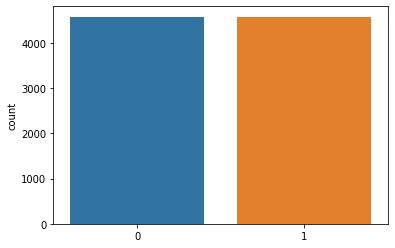

In [22]:
sns.countplot(y_sm )

In [23]:
row,col,channel = 128 ,128 , 3 
X_sm_reshaped = X_sm.reshape(len(X_sm),row,col,channel)

print(X_sm_reshaped.shape)
print(y_sm.shape)

(9162, 128, 128, 3)
(9162,)


In [27]:
img_test = []
for i in range (0,len(X_test)):
    brain_img_test =np.array(X_test)[i]
    img_test_arr = image.img_to_array(brain_img_test).astype(np.float32)
    img_test.append(img_test_arr/255)
X_scaled_test = np.array(img_test)

print(X_scaled_test.shape)

(1600, 128, 128, 3)


# Checking different architectures - ANN, InceptionV3, ResNet152V2, MobileNetV2

In [24]:
from tensorflow import keras
from tensorflow.keras import layers



model1 = keras.Sequential()
model1.add(layers.Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(128,128,3)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               125960704 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [25]:
model1.compile(optimizer='sgd',
             loss=keras.losses.binary_crossentropy,
             metrics=['accuracy'])


history1 = model1.fit(X_sm_reshaped,y_sm
          ,epochs=20,verbose=1,validation_split=0.2)

Epoch 1/20
230/230 [==============================] - 32s 116ms/step - loss: 0.6615 - accuracy: 0.6277 - val_loss: 0.8728 - val_accuracy: 0.1500
Epoch 2/20
230/230 [==============================] - 26s 111ms/step - loss: 0.6213 - accuracy: 0.6399 - val_loss: 0.1063 - val_accuracy: 1.0000
Epoch 3/20
230/230 [==============================] - 26s 111ms/step - loss: 0.6387 - accuracy: 0.6480 - val_loss: 4.2459 - val_accuracy: 0.0000e+00
Epoch 4/20
230/230 [==============================] - 26s 111ms/step - loss: 0.5989 - accuracy: 0.7112 - val_loss: 3.0814 - val_accuracy: 0.0000e+00
Epoch 5/20
230/230 [==============================] - 26s 111ms/step - loss: 0.5404 - accuracy: 0.7413 - val_loss: 1.2281 - val_accuracy: 0.2226
Epoch 6/20
230/230 [==============================] - 26s 111ms/step - loss: 0.4904 - accuracy: 0.7727 - val_loss: 6.2790 - val_accuracy: 0.0000e+00
Epoch 7/20
230/230 [==============================] - 25s 111ms/step - loss: 0.6256 - accuracy: 0.7141 - val_loss: 1.0

In [28]:
eval_score1 = model1.evaluate(X_scaled_test,y_test)
print('The loss of the evaluation :'+' '+str(eval_score1[0]*100))
print('The accuracy of the evaluation :'+' '+str(eval_score1[1]*100))

50/50 [==============================] - 4s 76ms/step - loss: 0.3608 - accuracy: 0.8356
The loss of the evaluation : 36.08427941799164
The accuracy of the evaluation : 83.56249928474426


In [29]:
from keras.applications import InceptionV3
num_classes = 1
model2 = keras.Sequential([
     InceptionV3(input_shape=(128,128,3),weights='imagenet',include_top=False), 
     layers.GlobalAveragePooling2D(),
     layers.Dense(num_classes, activation='sigmoid',name='preds'),
])
model2.layers[0].trainable= False

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
preds (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [30]:
model2.compile(optimizer='sgd',
             loss=keras.losses.binary_crossentropy,
             metrics=['accuracy'])


history2= model2.fit(X_sm_reshaped,y_sm
          ,epochs=20,verbose=1,validation_split=0.2)

Epoch 1/20
230/230 [==============================] - 14s 42ms/step - loss: 0.6794 - accuracy: 0.7101 - val_loss: 2.0448 - val_accuracy: 0.2526
Epoch 2/20
230/230 [==============================] - 8s 34ms/step - loss: 0.5466 - accuracy: 0.7758 - val_loss: 1.6450 - val_accuracy: 0.3742
Epoch 3/20
230/230 [==============================] - 7s 32ms/step - loss: 0.4855 - accuracy: 0.8059 - val_loss: 2.1638e-05 - val_accuracy: 1.0000
Epoch 4/20
230/230 [==============================] - 8s 33ms/step - loss: 0.9223 - accuracy: 0.7833 - val_loss: 1.3364e-04 - val_accuracy: 1.0000
Epoch 5/20
230/230 [==============================] - 7s 32ms/step - loss: 0.6476 - accuracy: 0.8035 - val_loss: 0.7845 - val_accuracy: 0.6612
Epoch 6/20
230/230 [==============================] - 8s 33ms/step - loss: 0.4035 - accuracy: 0.8331 - val_loss: 0.7065 - val_accuracy: 0.6869
Epoch 7/20
230/230 [==============================] - 8s 33ms/step - loss: 0.3815 - accuracy: 0.8390 - val_loss: 0.9300 - val_accurac

In [31]:
eval_score2 = model2.evaluate(X_scaled_test,y_test)
print('The loss of the evaluation :'+' '+str(eval_score2[0]*100))
print('The accuracy of the evaluation :'+' '+str(eval_score2[1]*100))

50/50 [==============================] - 3s 25ms/step - loss: 0.8813 - accuracy: 0.6762
The loss of the evaluation : 88.13106417655945
The accuracy of the evaluation : 67.62499809265137


In [32]:
from keras.applications import ResNet152V2
num_classes = 1
model3 = keras.Sequential([
     ResNet152V2(input_shape=(128,128,3),weights='imagenet',include_top=False), 
     layers.GlobalAveragePooling2D(),
     layers.Dense(num_classes, activation='sigmoid',name='preds'),
])
model3.layers[0].trainable= False

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 4, 4, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
preds (Dense)                (None, 1)                 2049      
Total params: 58,333,697
Trainable params: 2,049
Non-trainable params: 58,331,648
_________________________________________________________________


In [33]:
model3.compile(optimizer='sgd',
             loss=keras.losses.binary_crossentropy,
             metrics=['accuracy'])


history3 = model3.fit(X_sm_reshaped,y_sm
          ,epochs=20,verbose=1,validation_split=0.2)

Epoch 1/20
230/230 [==============================] - 29s 87ms/step - loss: 0.5596 - accuracy: 0.7142 - val_loss: 0.6631 - val_accuracy: 0.6634
Epoch 2/20
230/230 [==============================] - 17s 74ms/step - loss: 0.4753 - accuracy: 0.7935 - val_loss: 0.6080 - val_accuracy: 0.7147
Epoch 3/20
230/230 [==============================] - 17s 73ms/step - loss: 0.4454 - accuracy: 0.8034 - val_loss: 0.4806 - val_accuracy: 0.8047
Epoch 4/20
230/230 [==============================] - 17s 74ms/step - loss: 0.4249 - accuracy: 0.8185 - val_loss: 0.4597 - val_accuracy: 0.8123
Epoch 5/20
230/230 [==============================] - 17s 73ms/step - loss: 0.4276 - accuracy: 0.8087 - val_loss: 0.4566 - val_accuracy: 0.8107
Epoch 6/20
230/230 [==============================] - 17s 74ms/step - loss: 0.4113 - accuracy: 0.8232 - val_loss: 0.6768 - val_accuracy: 0.6678
Epoch 7/20
230/230 [==============================] - 17s 73ms/step - loss: 0.4101 - accuracy: 0.8167 - val_loss: 0.4382 - val_accuracy:

In [34]:
eval_score3 = model3.evaluate(X_scaled_test,y_test)
print('The loss of the evaluation :'+' '+str(eval_score3[0]*100))
print('The accuracy of the evaluation :'+' '+str(eval_score3[1]*100))

50/50 [==============================] - 6s 58ms/step - loss: 0.4084 - accuracy: 0.8281
The loss of the evaluation : 40.839290618896484
The accuracy of the evaluation : 82.8125


In [49]:
from keras.applications import MobileNetV2
num_classes = 1
model4 = keras.Sequential([
     MobileNetV2(input_shape=(128,128,3),weights="imagenet",include_top=False), 
     layers.GlobalAveragePooling2D(),
     layers.Dense(num_classes, activation='sigmoid',name='preds'),
])
model4.layers[0].trainable= False
# show model summary
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
preds (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [50]:
model4.compile(optimizer='sgd',
             loss=keras.losses.binary_crossentropy,
             metrics=['accuracy'])


history4 = model4.fit(X_sm_reshaped,y_sm
          ,epochs=20,verbose=1,validation_split=0.2)

Epoch 1/20
230/230 [==============================] - 7s 22ms/step - loss: 0.5542 - accuracy: 0.7134 - val_loss: 0.0264 - val_accuracy: 0.9989
Epoch 2/20
230/230 [==============================] - 4s 17ms/step - loss: 0.4266 - accuracy: 0.8068 - val_loss: 0.9232 - val_accuracy: 0.5155
Epoch 3/20
230/230 [==============================] - 4s 17ms/step - loss: 0.3874 - accuracy: 0.8340 - val_loss: 0.3660 - val_accuracy: 0.8472
Epoch 4/20
230/230 [==============================] - 4s 17ms/step - loss: 0.3619 - accuracy: 0.8451 - val_loss: 0.4726 - val_accuracy: 0.7807
Epoch 5/20
230/230 [==============================] - 4s 17ms/step - loss: 0.3432 - accuracy: 0.8485 - val_loss: 3.2923 - val_accuracy: 0.0082
Epoch 6/20
230/230 [==============================] - 4s 17ms/step - loss: 0.3860 - accuracy: 0.8380 - val_loss: 0.2498 - val_accuracy: 0.9083
Epoch 7/20
230/230 [==============================] - 4s 17ms/step - loss: 0.3361 - accuracy: 0.8578 - val_loss: 0.3902 - val_accuracy: 0.8314

In [51]:
eval_score4 = model4.evaluate(X_scaled_test,y_test)
print('The loss of the evaluation :'+' '+str(eval_score4[0]*100))
print('The accuracy of the evaluation :'+' '+str(eval_score4[1]*100))

50/50 [==============================] - 2s 13ms/step - loss: 0.3411 - accuracy: 0.8600
The loss of the evaluation : 34.10859405994415
The accuracy of the evaluation : 86.00000143051147


# Overfitting on all above architectures

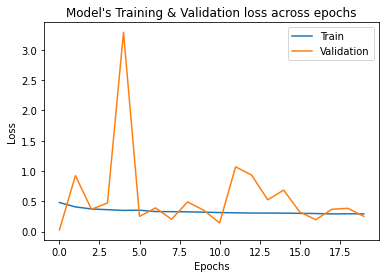

In [52]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

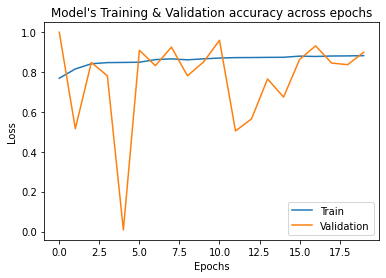

In [53]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title("Model's Training & Validation accuracy across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [54]:
eval_score = model4.evaluate(X_scaled_test,y_test)
print('The loss of the evaluation :'+' '+str(eval_score[0]*100))
print('The accuracy of the evaluation :'+' '+str(eval_score[1]*100))

50/50 [==============================] - 1s 13ms/step - loss: 0.3411 - accuracy: 0.8600
The loss of the evaluation : 34.10859405994415
The accuracy of the evaluation : 86.00000143051147


In [55]:

from sklearn.metrics import classification_report , confusion_matrix
y_pred = model4.predict_classes(X_scaled_test)
y_pred


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]], dtype=int32)

In [56]:
target_name = ['benign','malignant']
classification_report(y_true=y_test , y_pred=y_pred , output_dict=True , target_names= target_name )

{'benign': {'precision': 0.9156193895870736,
  'recall': 0.8869565217391304,
  'f1-score': 0.901060070671378,
  'support': 1150},
 'malignant': {'precision': 0.7325102880658436,
  'recall': 0.7911111111111111,
  'f1-score': 0.7606837606837606,
  'support': 450},
 'accuracy': 0.86,
 'macro avg': {'precision': 0.8240648388264586,
  'recall': 0.8390338164251208,
  'f1-score': 0.8308719156775694,
  'support': 1600},
 'weighted avg': {'precision': 0.8641199547842275,
  'recall': 0.86,
  'f1-score': 0.8615792334873607,
  'support': 1600}}

Text(69.0, 0.5, 'True Label')

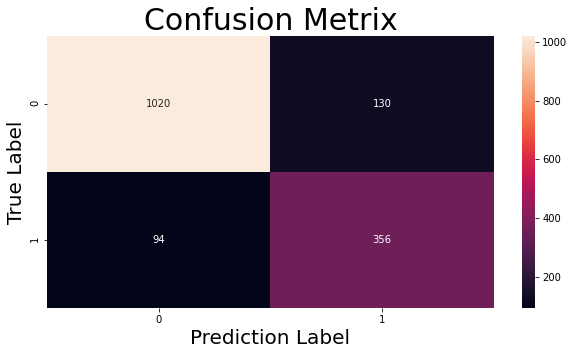

In [57]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred),annot=True , fmt='2d')
plt.title('Confusion Metrix',fontsize=30)
plt.xlabel('Prediction Label',fontsize=20)
plt.ylabel('True Label',fontsize=20)